In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-image-dataset/Y.npy
/kaggle/input/breast-cancer-image-dataset/X.npy


In [32]:
# basic package
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import optuna

#
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
#from efficientnet.keras import EfficientNetB1
from PIL import Image
from keras.utils import to_categorical
from keras.layers import GlobalAveragePooling2D
from keras.models import Model


## diacord Warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
def load_npdata(file_path):
    data = np.load(file_path)
    return data

In [4]:
X = load_npdata('/kaggle/input/breast-cancer-image-dataset/X.npy')
Y = load_npdata('/kaggle/input/breast-cancer-image-dataset/Y.npy')

In [38]:
# # 截取片段用于测试CV&parameter tuning
# np.save('X_subset.npy', X[2400:3200,])
# np.save('Y_subset.npy', Y[2400:3200,])

# X_subset = X[2400:3200,].copy()
# y_subset = Y[2400:3200,].copy()

In [10]:
X.shape 
#X_subset.shape

(5547, 50, 50, 3)

# EDA

In [12]:
# plotly 绘图 & 运行较慢
red_channel = X_subset[:,:,:,0].flatten()   # 红色通道
green_channel = X_subset[:,:,:,1].flatten() # 绿色通道
blue_channel = X_subset[:,:,:,2].flatten()  # 蓝色通道

# 创建直方图
fig = go.Figure()
fig.add_trace(go.Histogram(x=red_channel, nbinsx=256, name='Red Channel', marker_color='red', opacity=0.6))
fig.add_trace(go.Histogram(x=green_channel, nbinsx=256, name='Green Channel', marker_color='green', opacity=0.6))
fig.add_trace(go.Histogram(x=blue_channel, nbinsx=256, name='Blue Channel', marker_color='blue', opacity=0.6))

# 更新布局
fig.update_layout(
    title_text='Pixel Intensity Distribution for Each Color Channel',
    xaxis_title_text='Pixel Intensity',
    yaxis_title_text='Frequency',
    bargap=0.2,
    barmode='overlay'
)

# 显示图表
fig.show()

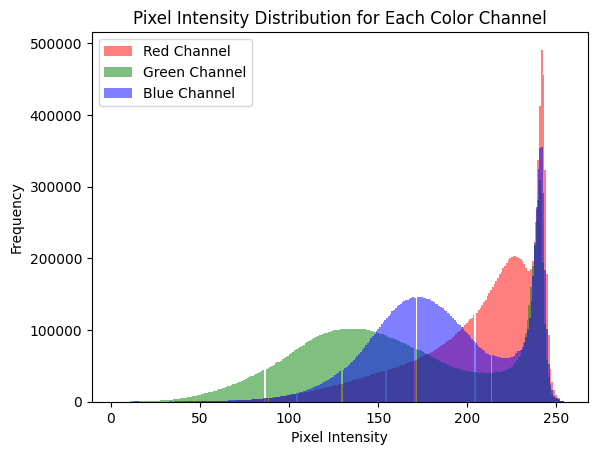

In [44]:
def Pixel_Intensity_plot(X):
    red_channel = X[:,:,:,0].flatten()   
    green_channel = X[:,:,:,1].flatten() 
    blue_channel = X[:,:,:,2].flatten()  

    
    bins = 256
    alpha = 0.5

    
    plt.hist(red_channel, bins=bins, color='red', alpha=alpha, label='Red Channel')
    plt.hist(green_channel, bins=bins, color='green', alpha=alpha, label='Green Channel')
    plt.hist(blue_channel, bins=bins, color='blue', alpha=alpha, label='Blue Channel')

    
    plt.title('Pixel Intensity Distribution for Each Color Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
Pixel_Intensity_plot(X)

## Data_Scaling

In [7]:
def data_Scaling(X):
    X = X.copy()
    num_images, height, width, channels = X.shape
    X_reshaped = X.reshape(num_images, -1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_images, height, width, channels)
    return X_scaled

In [45]:
X = data_Scaling(X)
Y = Y

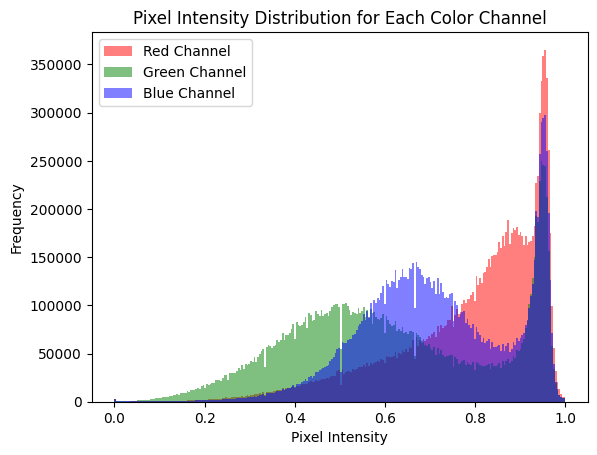

In [42]:
Pixel_Intensity_plot(X)

### Comparison of IDC and Non-IDC Sample Counts

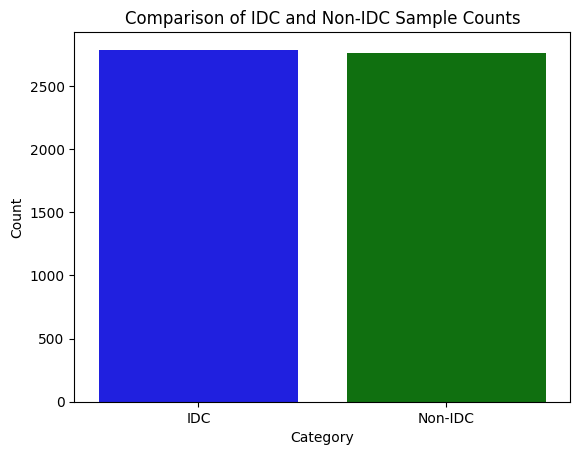

In [17]:
# 计算 IDC 和 Non-IDC 的数量
IDC_count = Y.sum()
Non_IDC_count = len(Y) - IDC_count

# 数据
categories = ['IDC', 'Non-IDC']
counts = [IDC_count, Non_IDC_count]

# 创建一个 DataFrame
import pandas as pd
data = pd.DataFrame({'Category': categories, 'Count': counts})

# 绘制条形图
sns.barplot(x='Category', y='Count', data=data, palette=['blue', 'green'])

# 添加标题
plt.title('Comparison of IDC and Non-IDC Sample Counts')

# 显示图表
plt.show()

# Logistic/SVM/Random forest/LGBM Classification

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (4714, 7500)
Testing Data Shape: (833, 7500)


### Logistic

CPU times: user 15.3 s, sys: 2.36 s, total: 17.6 s
Wall time: 5.08 s
CV_scores [0.75788288 0.75788288 0.73055242 0.7102593  0.72491545]


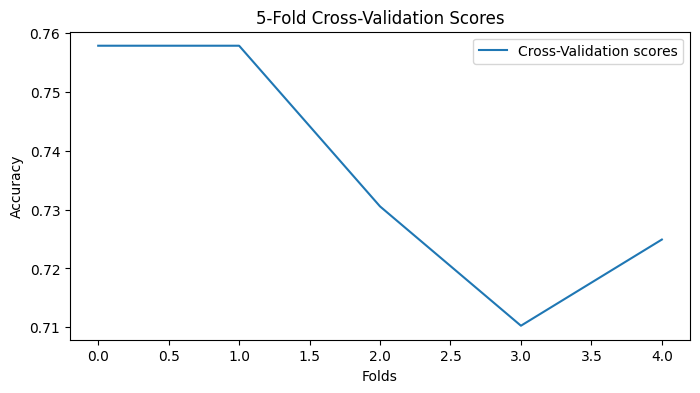

Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation score: 0.74


In [94]:
# 创建逻辑回归模型
logreg = LogisticRegression(max_iter=20)

# 进行 K 折交叉验证
%time kfold_scores = cross_val_score(logreg, X_train, Y_train, cv=5)

# 可视化输出分数
print('CV_scores',kfold_scores)
plt.figure(figsize=(8, 4))
plt.plot(kfold_scores, label='Cross-Validation scores')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.legend()
plt.show()

# 超参数优化
param_grid = {'C': [0.01,0.5, 0.1, 1], 'penalty': ['none', 'l2']}
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(X_train, Y_train)

# 打印最优参数和最优分数
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

In [95]:
best_logreg = LogisticRegression(**grid.best_params_, max_iter=50)
best_logreg.fit(X_train, Y_train)
y_pred_logreg = best_logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(Y_test, y_pred_logreg))
print(classification_report(Y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.7756756756756756
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       537
           1       0.82      0.72      0.77       573

    accuracy                           0.78      1110
   macro avg       0.78      0.78      0.78      1110
weighted avg       0.78      0.78      0.78      1110



### optuna + RF

In [ ]:
def objective(trial):
    
    # 设置随机森林的超参数空间
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2,20)
    
    # 实例化随机森林分类器
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=2024
    )
    
    # 在训练集上训练模型
    clf.fit(X_train, Y_train)

    # 执行K折交叉验证并收集每一轮的分数
    scores = cross_val_score(clf, X_train, Y_train, n_jobs=-1, cv=5)
    trial.set_user_attr("cv_scores", scores.tolist())  

    # 返回平均分数
    return scores.mean()

# 创建optuna的study对象
study = optuna.create_study(direction="minimize")

# 运行优化过程，指定优化的次数
study.optimize(objective, n_trials=20)

# 收集每次试验的分数
all_scores = [trial.user_attrs["cv_scores"] for trial in study.trials]

# 最佳参数
best_params = study.best_params

print("Best hyperparameters:", study.best_params)
print('Best Log Loss:', study.best_value) 

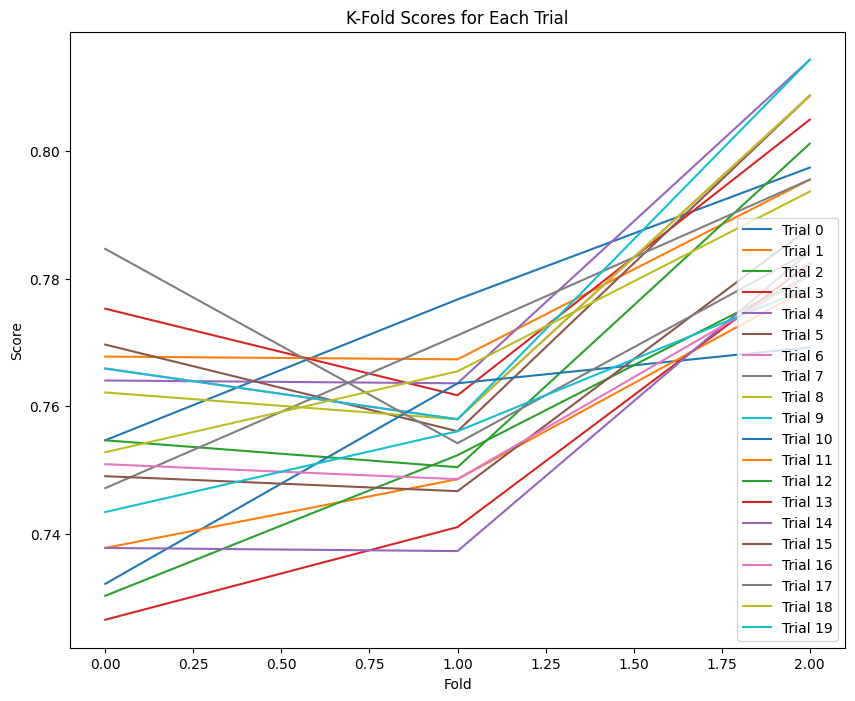

In [44]:
# 绘制每轮的K折交叉验证分数
plt.figure(figsize = (10,8))
for index, trial_scores in enumerate(all_scores):
    plt.plot(trial_scores, label=f'Trial {index}')

plt.title('K-Fold Scores for Each Trial')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

Random Forest Accuracy: 0.765906362545018
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       431
           1       0.75      0.77      0.76       402

    accuracy                           0.77       833
   macro avg       0.77      0.77      0.77       833
weighted avg       0.77      0.77      0.77       833



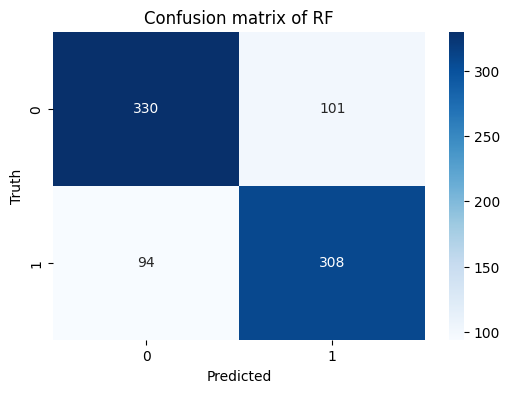

In [11]:
#best_params = {'n_estimators': 26, 'max_depth': 18}
best_rf = RandomForestClassifier(**best_params)

best_rf.fit(X_train, Y_train)

y_pred_rf = best_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))


cm = confusion_matrix(Y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',cmap = 'Blues')
plt.title('Confusion matrix of RF')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### SVM

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  13.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  12.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  13.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  13.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  12.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  11.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  11.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END ...........................C=1, gamma=1,

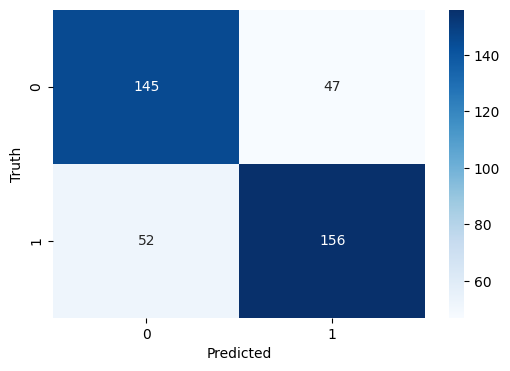

In [58]:
# 定义超参数网格
param_grid = {
    'C': [0.1, 1, 5,10],
    'gamma': [1, 0.1, 0.01 ],
    'kernel': ['rbf']
}

# 创建SVM模型
svc = SVC()

# 使用网格搜索
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=2)

# 在训练集上训练模型
grid_search.fit(X_train, Y_train)

# 打印最佳参数
print(f"Best Parameters: {grid_search.best_params_}")

# 使用最佳参数的模型进行预测
y_pred = grid_search.predict(X_test)

# 评估模型
print(classification_report(Y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


# 2.特征工程&拟合模型

### 尝试性处理:
1. 灰度化,
2. 直方图均衡化，
3. 高斯平滑

In [13]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        # 将图像数据标准化到 0-255 范围
        img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img_normalized = img_normalized.astype(np.uint8)

        # 灰度化
        gray = cv2.cvtColor(img_normalized, cv2.COLOR_RGB2GRAY)
        
        # 直方图均衡化
        equalized = cv2.equalizeHist(gray)
        
        smoothed = cv2.GaussianBlur(equalized, (3, 3), 0)

        processed_images.append(smoothed)

    return np.array(processed_images)

# 假设 X_subset 是您的子集图像数据
x_processed = preprocess_images(X)

In [14]:
def data_Scaling1(X):
    X = X.copy()
    num_images, height, width = X.shape
    X_reshaped = X.reshape(num_images, -1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_images, height, width)
    return X_scaled

x_processed = data_Scaling1(x_processed)
# 检查处理后的数据
print(x_processed.shape)

(5547, 50, 50)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_processed, Y, test_size=0.2)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print("Training Data Shape:", x_train.shape)
print("Testing Data Shape:", x_test.shape)

Training Data Shape: (4437, 2500)
Testing Data Shape: (1110, 2500)


### Logistic 回归

CPU times: user 2.5 s, sys: 754 ms, total: 3.26 s
Wall time: 943 ms
CV_scores [0.61711712 0.61677187 0.63029757 0.61406673]


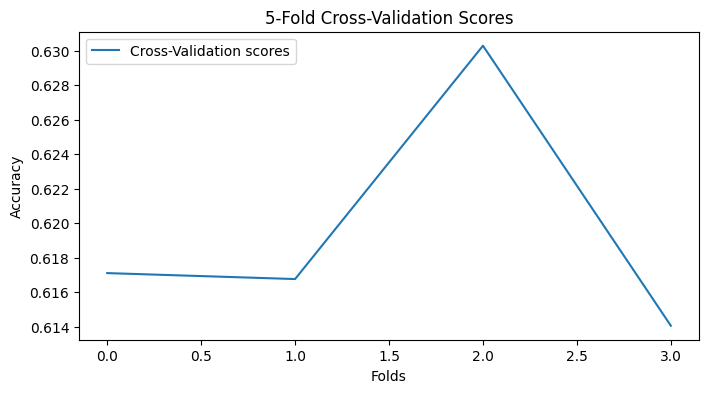

Best parameters: {'C': 0.05, 'penalty': 'l2'}
Best cross-validation score: 0.62


In [17]:
# 创建逻辑回归模型
logreg = LogisticRegression(max_iter=20)

# 进行 K 折交叉验证
%time kfold_scores = cross_val_score(logreg, x_train, y_train, cv=4)

# 可视化输出分数
print('CV_scores',kfold_scores)
plt.figure(figsize=(8, 4))
plt.plot(kfold_scores, label='Cross-Validation scores')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.legend()
plt.show()

# 超参数优化
param_grid = {'C': [0.05,0.5, 0.2,], 'penalty': ['none', 'l2']}
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(x_train, y_train)

# 打印最优参数和最优分数
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

In [20]:
best_logreg1 = LogisticRegression(**grid.best_params_, max_iter=50)
best_logreg1.fit(x_train, y_train)
y_pred_logreg1 = best_logreg1.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg1))
print(classification_report(y_test, y_pred_logreg1))

Logistic Regression Accuracy: 0.5945945945945946
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       555
           1       0.59      0.61      0.60       555

    accuracy                           0.59      1110
   macro avg       0.59      0.59      0.59      1110
weighted avg       0.59      0.59      0.59      1110



### Optuna+RF

In [16]:
def objective(trial):
    
    # 设置随机森林的超参数空间
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2,20)
    
    # 实例化随机森林分类器
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=2024
    )
    
    # 在训练集上训练模型
    clf.fit(x_train, y_train)

    # 执行K折交叉验证并收集每一轮的分数
    scores = cross_val_score(clf, x_train, y_train, n_jobs=-1, cv=5)
    trial.set_user_attr("cv_scores", scores.tolist())  

    # 返回平均分数
    return scores.mean()

# 创建optuna的study对象
study = optuna.create_study(direction="minimize")

# 运行优化过程，指定优化的次数
study.optimize(objective, n_trials=20)

# 收集每次试验的分数
all_scores = [trial.user_attrs["cv_scores"] for trial in study.trials]

# 最佳参数
best_params = study.best_params

print("Best hyperparameters:", study.best_params)
print('Best Log Loss:', study.best_value) 



[I 2024-01-25 06:33:55,169] A new study created in memory with name: no-name-e2a46368-253a-41ce-845a-c5f541626c70
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[I 2024-01-25 06:34:07,561] Trial 0 finished with value: 0.6330854180752761 and parameters: {'n_estimators': 57, 'max_depth': 10}. Best 

Best hyperparameters: {'n_estimators': 10, 'max_depth': 2}
Best Log Loss: 0.5963488843813387


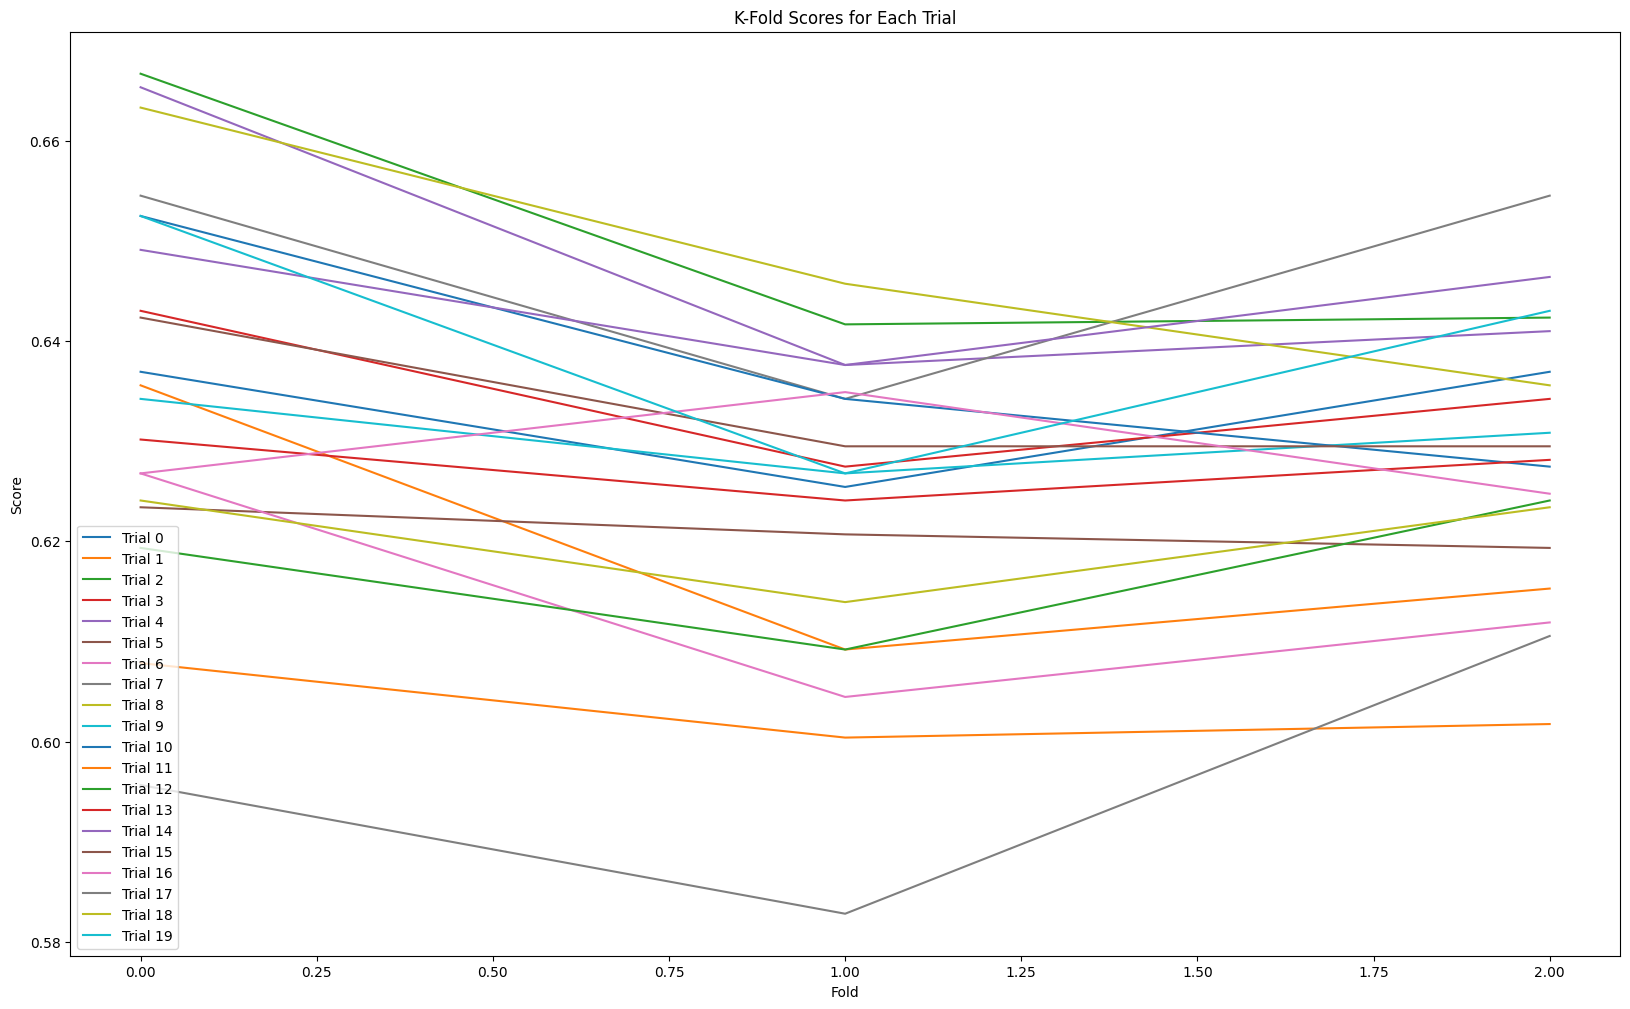

Random Forest Accuracy: 0.6378378378378379
              precision    recall  f1-score   support

           0       0.68      0.52      0.58       549
           1       0.62      0.76      0.68       561

    accuracy                           0.64      1110
   macro avg       0.65      0.64      0.63      1110
weighted avg       0.64      0.64      0.63      1110



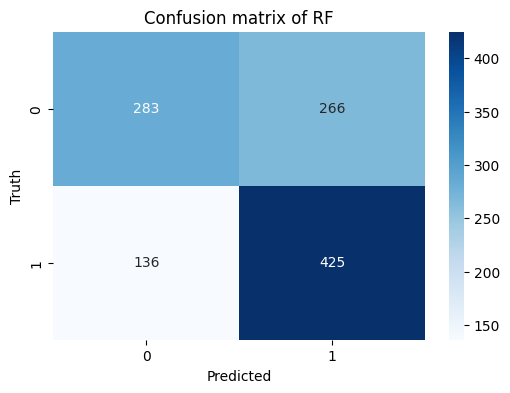

In [17]:
# 绘制每轮的K折交叉验证分数
plt.figure(figsize = (20,12))
for index, trial_scores in enumerate(all_scores):
    plt.plot(trial_scores, label=f'Trial {index}')

plt.title('K-Fold Scores for Each Trial')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

best_rf1 = RandomForestClassifier(**best_params)

best_rf1.fit(x_train, y_train)

y_pred_rf1 = best_rf1.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf1))
print(classification_report(y_test, y_pred_rf1))


cm = confusion_matrix(y_test, y_pred_rf1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',cmap = 'Blues')
plt.title('Confusion matrix of RF')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### SVM model

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  25.0s
[CV] END ......................C=0.1, gamma=0.01,

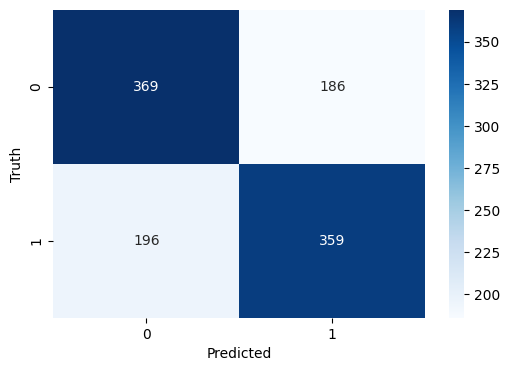

In [12]:
# 定义超参数网格
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

# 创建SVM模型
svc = SVC()

# 使用网格搜索
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=2,cv=3)

# 在训练集上训练模型
grid_search.fit(x_train, y_train)

# 打印最佳参数
print(f"Best Parameters: {grid_search.best_params_}")

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       555
           1       0.66      0.65      0.65       555

    accuracy                           0.66      1110
   macro avg       0.66      0.66      0.66      1110
weighted avg       0.66      0.66      0.66      1110



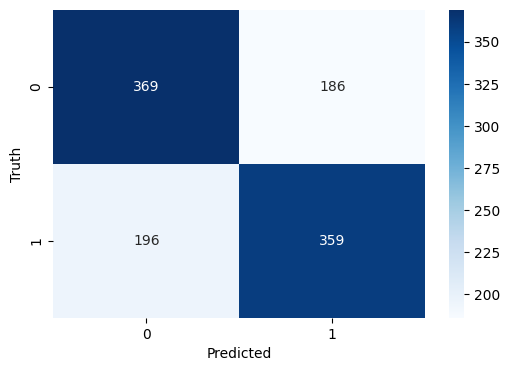

In [16]:
# 使用最佳参数的模型进行预测
y_pred1 = grid_search.predict(x_test)

# 评估模型
print(classification_report(y_test, y_pred1))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# 3.Keras CNN classification

In [21]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2)
Y_train1 = to_categorical(Y_train1)
Y_test1 = to_categorical(Y_test1)
X_train.shape

(4714, 7500)

In [22]:
#设置早停 waiting epochs = 5
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
#layer 1
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
#layer 2
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#layer 3
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
#layer 4
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
#layer 5
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())

#output layer
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

#complie model
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 64)        256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       7

In [23]:
# 定义ModelCheckpoint回调
checkpoint = ModelCheckpoint('best_model.h5',  
                             monitor='val_loss',  
                             verbose=1,
                             save_best_only=True,  # 只保存在验证集上性能最好的模型
                             mode='min')  


%time history = model.fit(X_train1, Y_train1, validation_data = (X_test1, Y_test1), epochs = 36, batch_size = 64,callbacks=[checkpoint,early_stop])

Epoch 1/36


2024-01-25 06:43:25.701182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/70 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.7325
Epoch 1: val_loss improved from inf to 4.36172, saving model to best_model.h5
70/70 [==============================] - 24s 177ms/step - loss: 0.5833 - accuracy: 0.7325 - val_loss: 4.3617 - val_accuracy: 0.4874
Epoch 2/36
70/70 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.7830
Epoch 2: val_loss improved from 4.36172 to 1.65019, saving model to best_model.h5
70/70 [==============================] - 11s 154ms/step - loss: 0.4795 - accuracy: 0.7830 - val_loss: 1.6502 - val_accuracy: 0.5225
Epoch 3/36
70/70 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8005
Epoch 3: val_loss improved from 1.65019 to 0.62645, saving model to best_model.h5
70/70 [==============================] - 11s 155ms/step - loss: 0.4501 - accuracy: 0.8005 - val_loss: 0.6265 - val_accuracy: 0.6964
Epoch 4/36
70/70 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.82

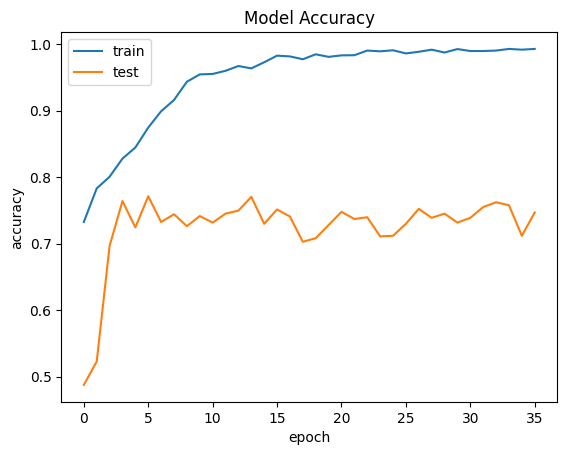

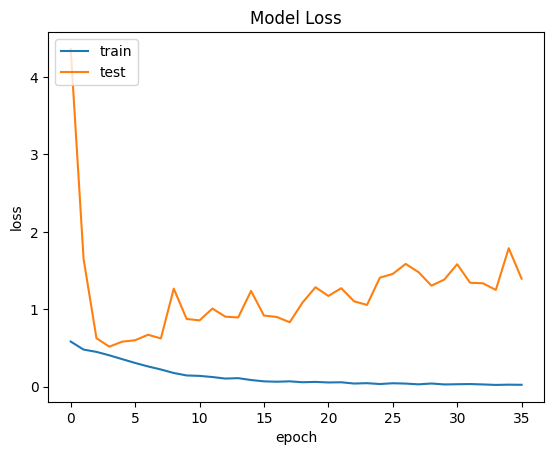

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

35/35 [==============================] - 1s 17ms/step
Accuracy: 0.7639639639639639


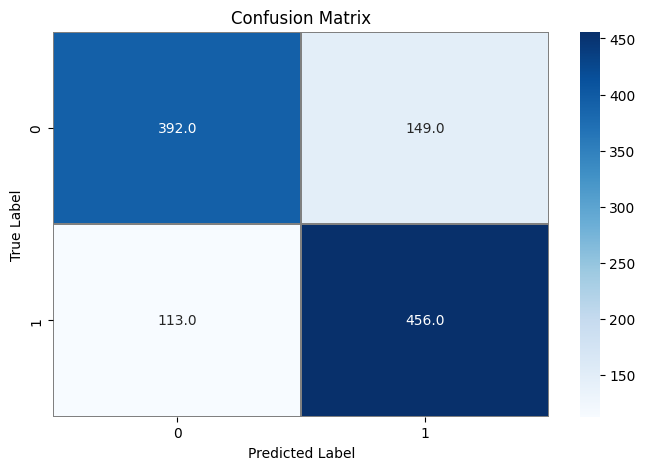

In [85]:
# 加载模型
model.load_weights('best_model.h5')
Y_pred = model.predict(X_test1)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test1,axis = 1) 

accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 4.Transfering based on VGG

In [96]:
# !pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 925.5 kB/s eta 0:00:00a 0:00:01


## 图像放缩到net支持的维度

In [42]:
# 加载不包含顶层的EfficientNet B1模型
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(50, 50,3))

from keras.layers import GlobalAveragePooling2D
#冻结base_model参数
for layer in base_model.layers:
    layer.trainable = False

#添加输出层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
predictions = Dense(2, activation='softmax')(x)

model_Efficient = Model(inputs=base_model.input, outputs=predictions)

model_Efficient.compile(Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

model_Efficient.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [43]:
checkpoint = ModelCheckpoint('best_VGG_model.h5',  
                             monitor='val_accuracy',  # 监测指标是验证集的准确率
                             verbose=1, 
                             save_best_only=True,  
                             mode='max')  # 模式为'max'因为监测的是准确率

In [44]:
%time history_2 = model_Efficient.fit(X_train1, Y_train1, validation_data = (X_test1, Y_test1), epochs = 30, batch_size = 40,callbacks=[checkpoint])

Epoch 1/30
111/111 [==============================] - ETA: 0s - loss: 3.4207 - accuracy: 0.6105
Epoch 1: val_accuracy improved from -inf to 0.66126, saving model to best_VGG_model.h5
111/111 [==============================] - 6s 33ms/step - loss: 3.4207 - accuracy: 0.6105 - val_loss: 0.9309 - val_accuracy: 0.6613
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.4104 - accuracy: 0.6250
Epoch 2: val_accuracy did not improve from 0.66126
111/111 [==============================] - 2s 21ms/step - loss: 1.4080 - accuracy: 0.6232 - val_loss: 0.7235 - val_accuracy: 0.6532
Epoch 3/30
111/111 [==============================] - ETA: 0s - loss: 1.0061 - accuracy: 0.6444
Epoch 3: val_accuracy improved from 0.66126 to 0.69369, saving model to best_VGG_model.h5
111/111 [==============================] - 3s 23ms/step - loss: 1.0061 - accuracy: 0.6444 - val_loss: 0.6220 - val_accuracy: 0.6937
Epoch 4/30
110/111 [============================>.] - ETA: 0s - loss: 0.8467 - accuracy:

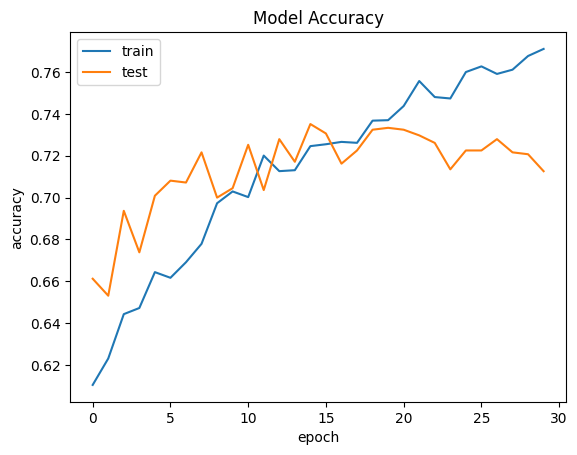

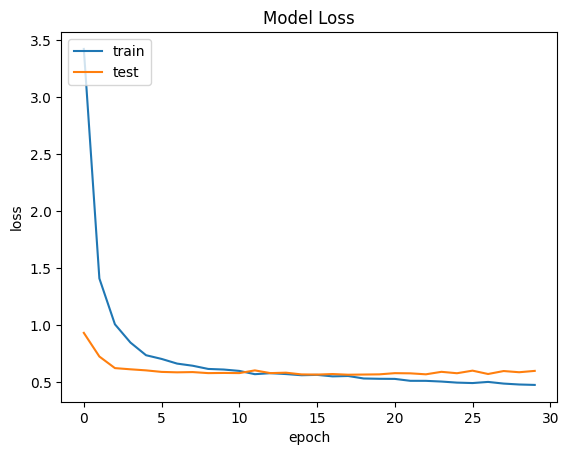

In [45]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

35/35 [==============================] - 0s 13ms/step


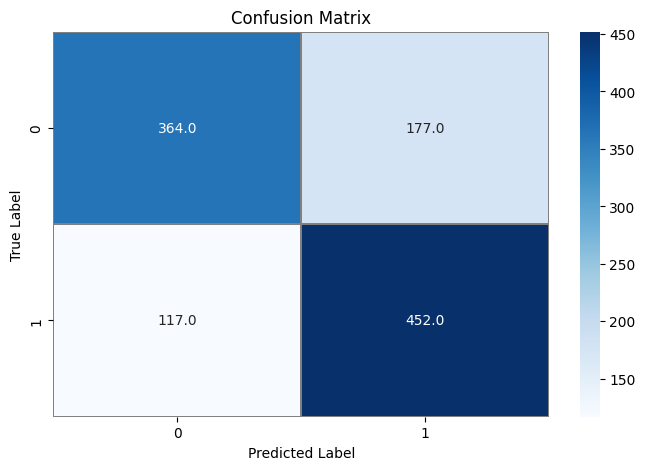

In [86]:
model_Efficient.load_weights('best_VGG_model.h5')
Y_pred_inc = model_Efficient.predict(X_test1)
Y_pred_classes = np.argmax(Y_pred_inc,axis = 1) 
Y_true = np.argmax(Y_test1,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

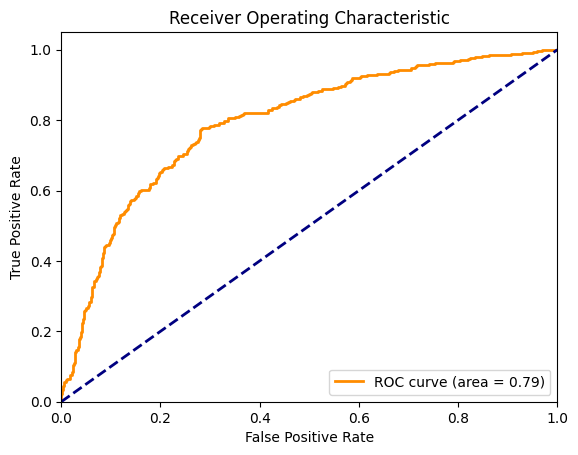

In [87]:
from sklearn.metrics import roc_curve, auc
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_inc[:, 1])  # 使用正类的概率
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

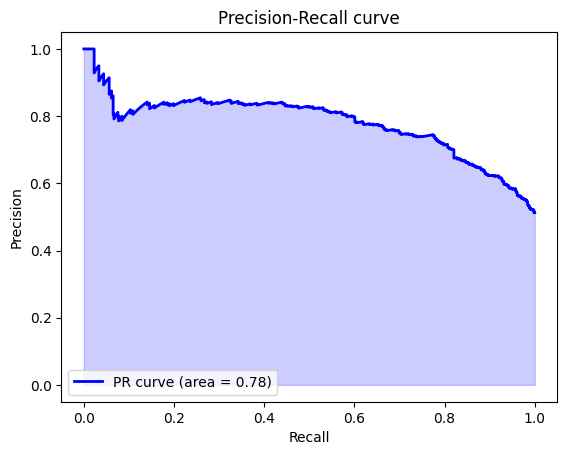

In [88]:


# 计算PR曲线
precision, recall, _ = precision_recall_curve(Y_true, Y_pred_inc[:, 1])
average_precision = average_precision_score(Y_true, Y_pred_inc[:, 1])

# 绘制PR曲线
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# 5.ResNet 50

## 先做图像处理，放大维度到ResNet能处理的维度

In [47]:
def resize_images(X, size=(240, 240)):
    X_resized = np.zeros((X.shape[0], *size, X.shape[3]), dtype=np.uint8)
    for i in range(X.shape[0]):
        img = Image.fromarray((X[i] * 255).astype(np.uint8))  # 将浮点类型转换为uint8
        img_resized = img.resize(size, Image.ANTIALIAS)
        X_resized[i] = np.array(img_resized)
    return X_resized

# 假设X_subset是您的原始图像数据集
X_retrain = resize_images(X_train1)
X_retest = resize_images(X_test1)

/tmp/ipykernel_25/4254038636.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(size, Image.ANTIALIAS)


(4437, 240, 240, 3)


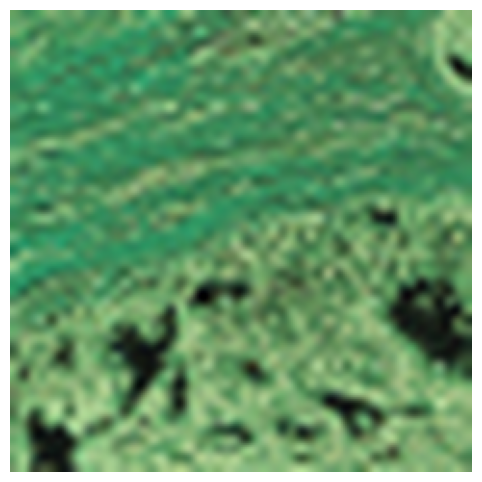

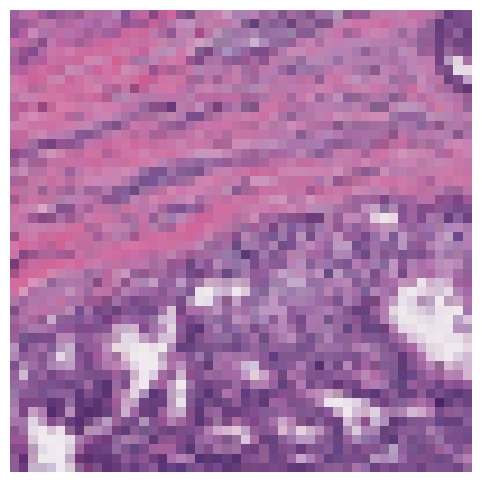

In [50]:
print(X_retrain.shape)

plt.figure(figsize = (8,6))
img_to_show = X_retrain[5]
plt.imshow(img_to_show)
plt.axis('off')  # 不显示坐标轴
plt.show

plt.figure(figsize = (8,6))
img_to_show = X_train1[5]
plt.imshow(img_to_show)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [57]:
from keras.applications.resnet50 import ResNet50

In [61]:
# 加载预训练的InceptionV3模型
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# 冻结base_model1参数
for layer in base_model1.layers:
    layer.trainable = False

# 添加自定义层
x = base_model1.output
x = GlobalAveragePooling2D()(x)  # 添加全局平均池化层
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# 创建新的模型
model_inception = Model(inputs=base_model1.input, outputs=predictions)

# 编译模型
model_inception.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 显示模型摘要
model_inception.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 246, 3)          0         ['input_13[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 120, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 120, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [65]:
checkpoint = ModelCheckpoint('best_ResNet50_model.h5',  
                             monitor='val_accuracy',  # 监测指标是验证集的准确率
                             verbose=1, 
                             save_best_only=True,  
                             mode='max')  # 模式为'max'因为监测的是准确率

#设置早停 waiting epochs = 5
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [66]:
%time history_3 = model_inception.fit(X_retrain, Y_train1, validation_data = (X_retest, Y_test1), epochs = 30, batch_size = 50,callbacks=[checkpoint,early_stop])

Epoch 1/30
89/89 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9714
Epoch 1: val_accuracy improved from -inf to 0.76396, saving model to best_ResNet50_model.h5
89/89 [==============================] - 21s 231ms/step - loss: 0.0732 - accuracy: 0.9714 - val_loss: 1.3319 - val_accuracy: 0.7640
Epoch 2/30
89/89 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9799
Epoch 2: val_accuracy did not improve from 0.76396
89/89 [==============================] - 21s 234ms/step - loss: 0.0605 - accuracy: 0.9799 - val_loss: 1.1525 - val_accuracy: 0.7622
Epoch 3/30
89/89 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9937
Epoch 3: val_accuracy improved from 0.76396 to 0.77387, saving model to best_ResNet50_model.h5
89/89 [==============================] - 21s 232ms/step - loss: 0.0224 - accuracy: 0.9937 - val_loss: 1.3839 - val_accuracy: 0.7739
Epoch 4/30
89/89 [==============================] - ETA: 0s - loss: 0.0190 - accurac

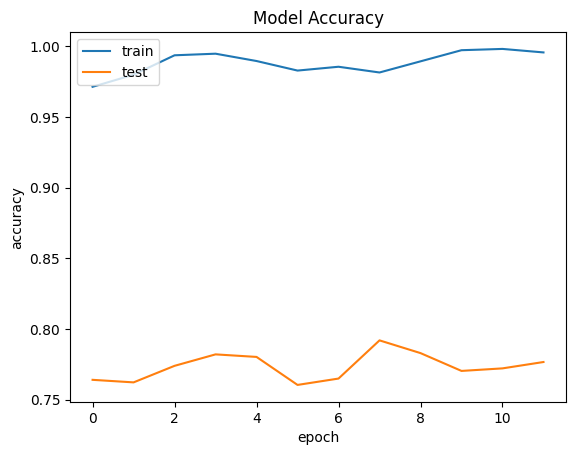

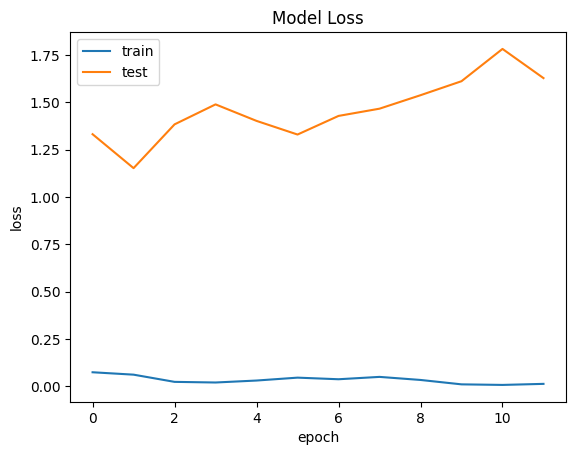

In [67]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

35/35 [==============================] - 4s 113ms/step
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       541
           1       0.79      0.80      0.80       569

    accuracy                           0.79      1110
   macro avg       0.79      0.79      0.79      1110
weighted avg       0.79      0.79      0.79      1110



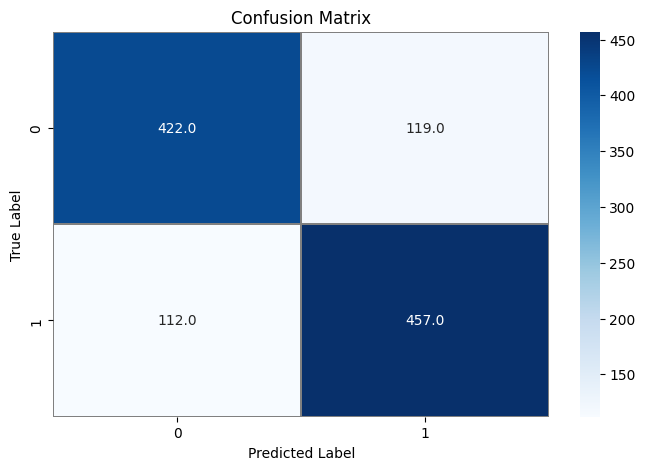

In [71]:
model_inception.load_weights('best_ResNet50_model.h5')

Y_pred_inc = model_inception.predict(X_retest)

Y_pred_classes = np.argmax(Y_pred_inc,axis = 1) 
Y_true = np.argmax(Y_test1,axis = 1) 
print(classification_report(Y_true, Y_pred_classes))

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

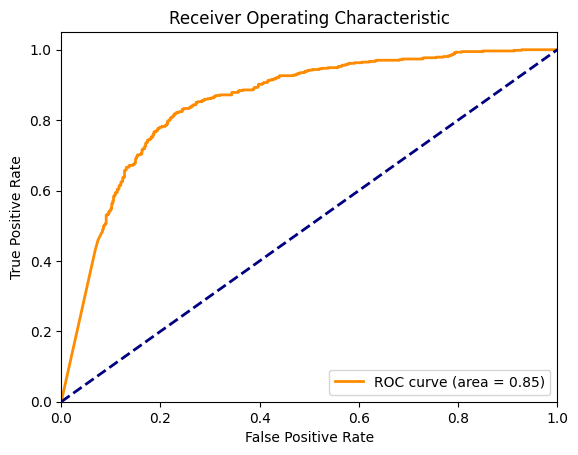

In [73]:
from sklearn.metrics import roc_curve, auc
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_inc[:, 1])  # 使用正类的概率
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

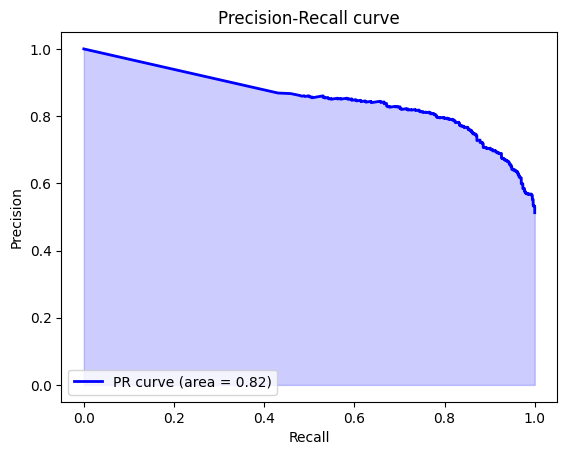

In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 计算PR曲线
precision, recall, _ = precision_recall_curve(Y_true, Y_pred_inc[:, 1])
average_precision = average_precision_score(Y_true, Y_pred_inc[:, 1])

# 绘制PR曲线
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()
